## Simulating LSST-like image time-series of lensed type Ia supernovae

### Import python libraries, LSST characteristics and functions

In [1]:
import pickle as pickle
from class_telescope import Telescope
from image_time_series import simulate_time_series_images
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rc("font", family="serif")
plt.rc("text", usetex=True)

### Parameter distributions 

Sample $z_l$, $z_s$ and $\theta_E$ from MC sample from Wojtak et al. (2019).


In [2]:
# ---------------------------------
telescope = 'LSST'
bandpasses = ['r', 'i', 'z', 'y']
num_samples = 1000
# ---------------------------------

lsst = Telescope(telescope, bandpasses, num_samples)


Setting up OpSim Summary generator...
 reading from database sqlite:///../data/OpSim_databases/baseline_v3.0_10yrs.db
We have filterNull set to False
checking that summary table read in

Reading in raw tables successful
replacing names works
dropping duplicates works
dithered column names exists 
Changing units for fbsv2 from degrees


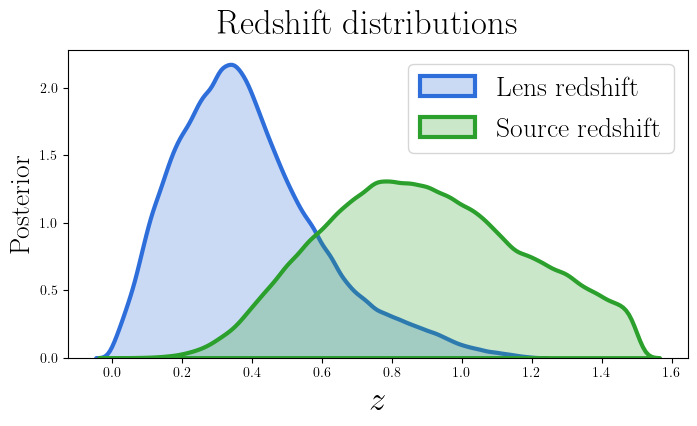

In [3]:
lsst.plot_redshifts()

### Seeing distributions
Sample the PSF from the predicted seeing distribution for the <b> baseline v2.0 </b> observing strategy for 10 years.

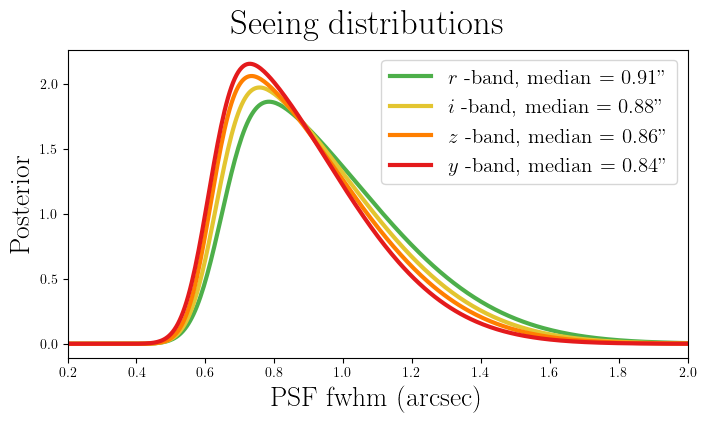

In [4]:
lsst.plot_seeing_distributions()


### Cadence

Sample the cadence from the predicted distribution for the <b> baseline v2.0 </b> observing strategy for the LSST Wide, Fast, Deep survey from Catarina Alves' simulations.


In [5]:
# lsst.plot_cadence()


### Generation of training and test sets


  0%|                                                      | 0/1 [00:00<?, ?it/s]

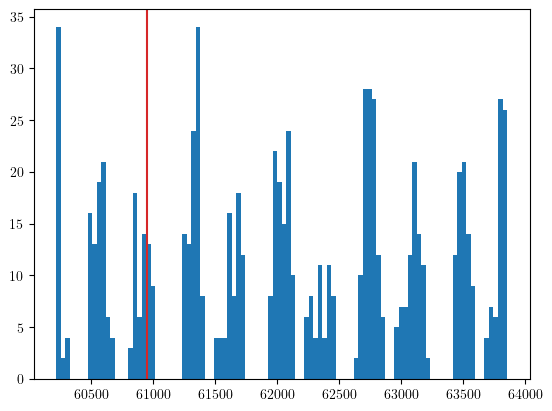

Theoretically visible with image multiplicity method?            False
Theoretically visible with magnification method?                 True
Observations allow for detection with image multiplicity method? False
Observations allow for detection with magnification method?      True
 
Lens redshift:  0.98
Supernova redshift:  1.38
Einstein radius:  0.38
Time delays:  [ 0.   26.79] days
Macro magnification:  [4.95 2.93]
Microlensing contribution at peak (magnitudes):  0.0
Hubble constant:  67.8
Time-delay distance:  15865.04
Peak brightness images for r,i,z,y bands:
[[  inf   inf]
 [23.6  24.47]
 [23.13   inf]
 [  inf   inf]]
 


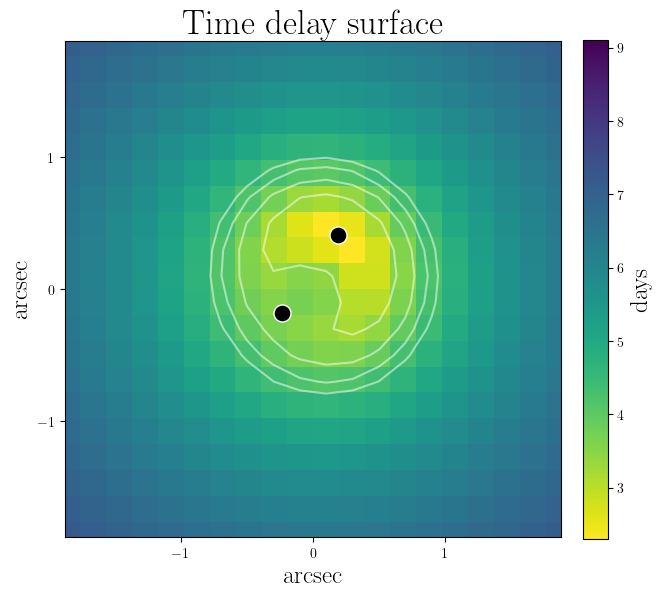

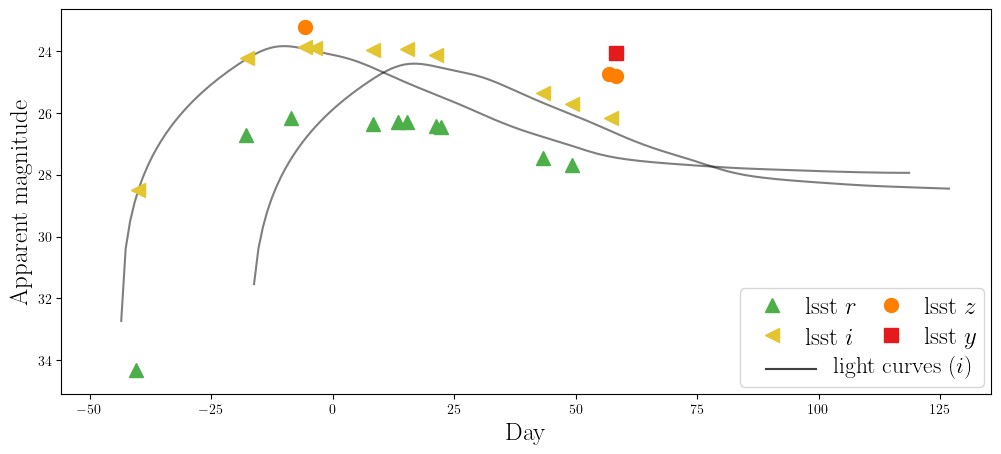

39.00067977593795 24
35.543041186673534 22.82764152878568
32.63436737339059 22.275486873078815
33.48072124379964 21.754920451382375


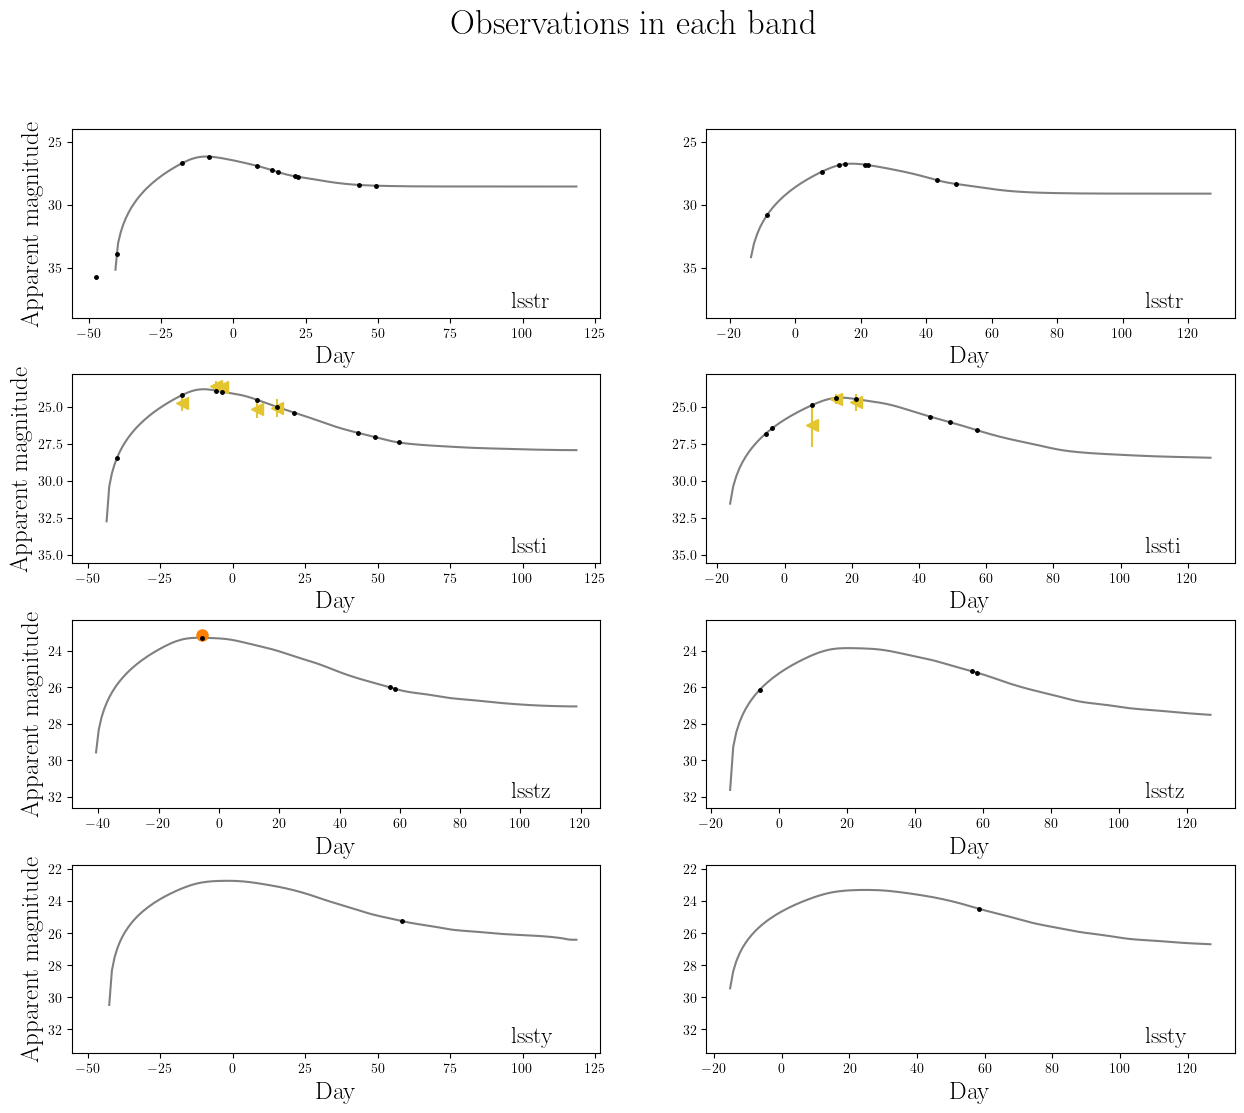

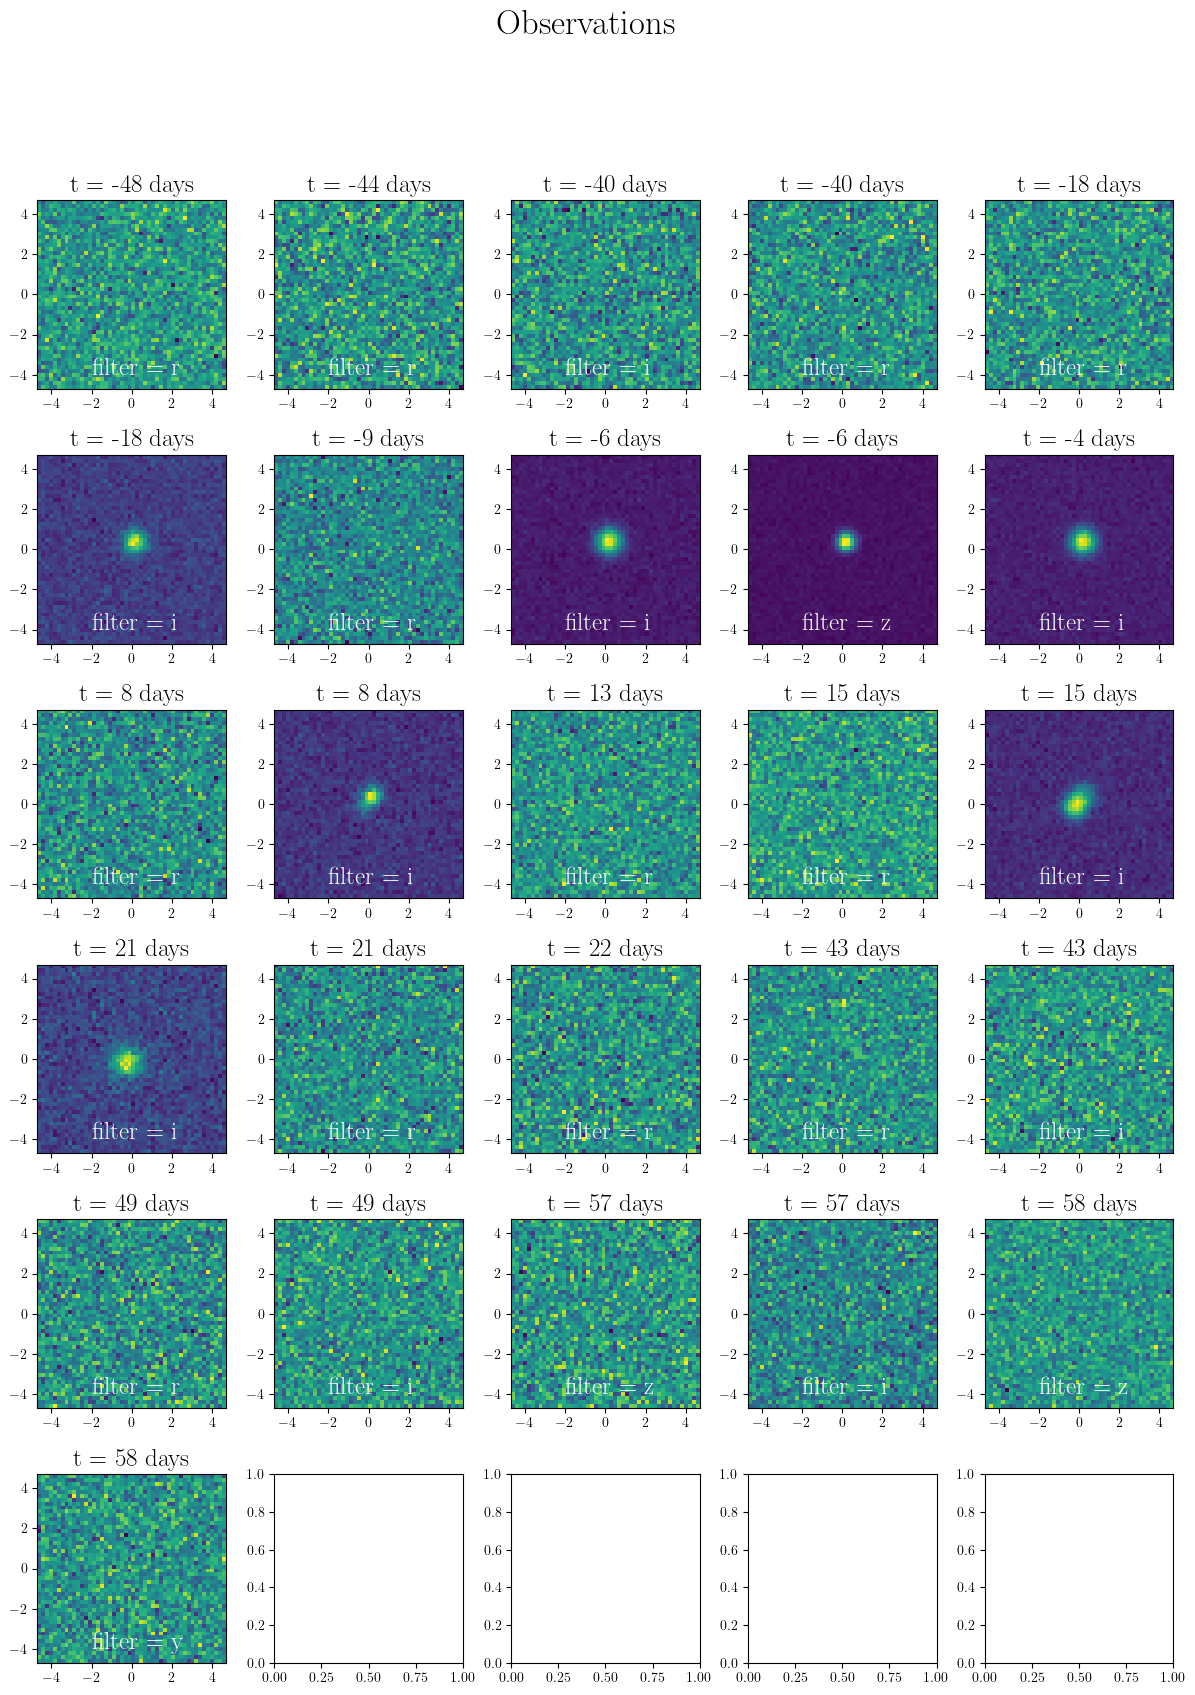

100%|██████████████████████████████████████████████| 1/1 [00:04<00:00,  4.99s/it]

Done!
Simulating images took  5.0 seconds ( 0.0 hours) to complete.
Number of image-time series generated:  1
Number of configurations tried:  1
Number of attempts:  8
 


100%|██████████████████████████████████████████████| 1/1 [00:05<00:00,  5.39s/it]

                                         time_series  z_source    z_lens  \
0  [[[-0.9502356769811305, 1.1549014736697045, 0....  1.376453  0.980037   

     H0   theta_E                                           obs_peak  \
0  67.8  0.375766  [[inf, inf], [23.600170634317028, 24.467361917...   

                                           obs_times  \
0  [-47.50467077056237, -43.51057399169804, -40.0...   

                                           obs_bands  \
0  [r, r, i, r, r, i, r, i, z, i, r, i, r, r, i, ...   

                                           model_mag  \
0  [[35.753283530484694, inf], [inf, inf], [28.49...   

                                             obs_mag  ...       obs_end  \
0  [[inf, inf], [inf, inf], [inf, inf], [inf, inf...  ...  61012.060369   

  mult_method_peak mult_method mag_method_peak mag_method  \
0            False       False            True       True   

                                     coords  \
0  [337.9950182603298, -13.752300037852491

In [10]:
num_samples = 1            # Total number of lens systems to be generated  
batch_size = 1             # Number of lens systems that is saved together in a batch
batch = 1                     # Starting number of the batch
num_images = 2                # Choose between 2 (for doubles) and 4 (for quads)
obs_upper_limit = 200         # Upper limit of number of observations
obs_lower_limit = 5           # Lower limit of number of observations
fixed_H0 = True               # Bool, if False: vary H0. if True: fix H0 to 70 km/s/Mpc (for the evaluation set)
add_microlensing = False      # Bool, if False: Only macro magnification. if True: Add effects of microlensing

Show = True                   # Bool, if True: Show figures and print information about the lens systems
Save = False                  # Bool, if True: Save image time-series
path = "../processed_data/Baseline_v_3_0/" # Path to folder in which to save the results


df, timings = simulate_time_series_images(num_samples, batch_size, batch, num_images, add_microlensing, 
                                 obs_lower_limit, obs_upper_limit, fixed_H0, lsst, Show, Save, path)


### Calculate limiting magnitude including weather effects

In [ ]:
fluxerr = np.array([6, 5, 4, 10])
flux = np.array([4, 45, 67, 20])

fluxcov = np.diag(fluxerr**2)
print(fluxcov)
# Add random (but correlated) noise to the fluxes
fluxchol = np.linalg.cholesky(fluxcov)
print(fluxchol)
print(" ")
randoms = np.random.randn(len(flux))
print(randoms)
print(fluxchol.dot(randoms))
newflux = flux + fluxchol.dot(randoms)

print(newflux)

In [ ]:
opsim_times = np.array([0, 0.4, 0.6, 0.9, 2, 2.8, 2.5, 8, 9, 9.9])
opsim_lim_mag = np.ones_like(opsim_times) * 20
opsim_filters = np.array(['i', 'r', 'i', 'r', 'i', 'i', 'i', 'i', 'u', 'u'])
IDs = np.arange(0, len(opsim_times))
print(IDs)

coadd_times, N_coadds, coadd_filters = [], [], []

ID_list = []

for t1 in range(len(opsim_times)):
    print(" ")
    print(t1)
    
    if IDs[t1] in ID_list:
        print("stop!")
        continue
    
    lim_mag_list = [opsim_lim_mag[t1]]
    times_list = [opsim_times[t1]]
    ID_list.append(IDs[t1])

    for t2 in range(t1+1, len(opsim_times)):

        # Same day?
        if opsim_times[t2] - opsim_times[t1] >= 1:
            break

        # Same filter?
        if opsim_filters[t1] == opsim_filters[t2]:
            lim_mag_list.append(opsim_lim_mag[t2])
            times_list.append(opsim_times[t2])
            ID_list.append(IDs[t2])
            print(t2)
            
    print(lim_mag_list)
    print(ID_list)
    coadd_times.append(np.mean(times_list))
    N_coadds.append(len(times_list))
    coadd_filters.append(opsim_filters[t1])
    
print(" ")
print("coadd_times: ", coadd_times)
print("N_coadds: ", N_coadds)
print("coadd_filters: ", coadd_filters)

In [ ]:
import sncosmo

index = 8
zeropoint = df['zeropoint'][index]
skysig = np.array(df['skysig'][index])
mag_im = df['brightness_im'][index]
mag_im = mag_im[:len(zeropoint)]
bands = np.array(df['obs_bands'][index])

ab = sncosmo.get_magsystem('ab')
zpfluxes = np.array([ab.zpbandflux('lsst' + b) for b in bands])

print(bands)


In [ ]:
# Calculate limiting magnitude from sky noise and zeropoint
m_lim = zeropoint - 2.5*np.log10(5 * np.array(skysig))
print("Limiting magnitudes: ")
print(m_lim)

In [ ]:
# Convert image magnitudes back into fluxes
# flux_im = 10**(mag_im / -2.5) * zpfluxes

print(skysig[bands == 'r'])
print(skysig[bands == 'i'])
print(skysig[bands == 'z'])
print(skysig[bands == 'y'])

### Retrieve light curve observations

In [ ]:
print(min(df['brightness_unresolved'][0]))


times = np.array(df['obs_times'][0])
bands = np.array(df['obs_bands'][0])
mags = df['brightness_im'][0]
mags_unresolved = df['brightness_unresolved'][0]

print(times[-1] - times[0])
print(df['obs_end'][0] - df['obs_start'][0])
print(len(times))

mask_r = np.where(bands == 'r')
mask_i = np.where(bands == 'i')
mask_z = np.where(bands == 'z')
mask_y = np.where(bands == 'y')

print(df['brightness_im'][0][:,1][mask_y])

plt.figure()
plt.plot(times[mask_r], mags[:,0][mask_r], color='C0', label="r")
plt.plot(times[mask_r], mags[:,1][mask_r], color='C0')

plt.plot(times[mask_i], mags[:,0][mask_i], color='C1', label="i")
plt.plot(times[mask_i], mags[:,1][mask_i], color='C1')
plt.plot(times[mask_i], mags_unresolved[mask_i], '.', color='black')

plt.plot(times[mask_z], mags[:,0][mask_z], color='C2', label="z")
plt.plot(times[mask_z], mags[:,1][mask_z], color='C2')

plt.plot(times[mask_y], mags[:,0][mask_y], color='C3', label="y")
plt.plot(times[mask_y], mags[:,1][mask_y], color='C3')

plt.ylim(31, 22)
plt.ylabel("Apparent magnitude")
plt.xlabel("Time (days)")
plt.legend()
